In [1]:
#Download the data
!wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2025-03-07 11:42:19--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

SingleElectronPt50_ 100%[===================>] 122.95M  18.6MB/s    in 8.1s    

2025-03-07 11:42:28 (15.2 MB/s) - ‘SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [128927319/128927319]

--2025-03-07 11:42:28--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awa

In [2]:
import h5py
import numpy as np


f = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
g = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron = np.asarray(f['X'])
photon = np.asarray(g['X'])

In [3]:
electron.shape, photon.shape

((249000, 32, 32, 2), (249000, 32, 32, 2))

#### Let's visualize

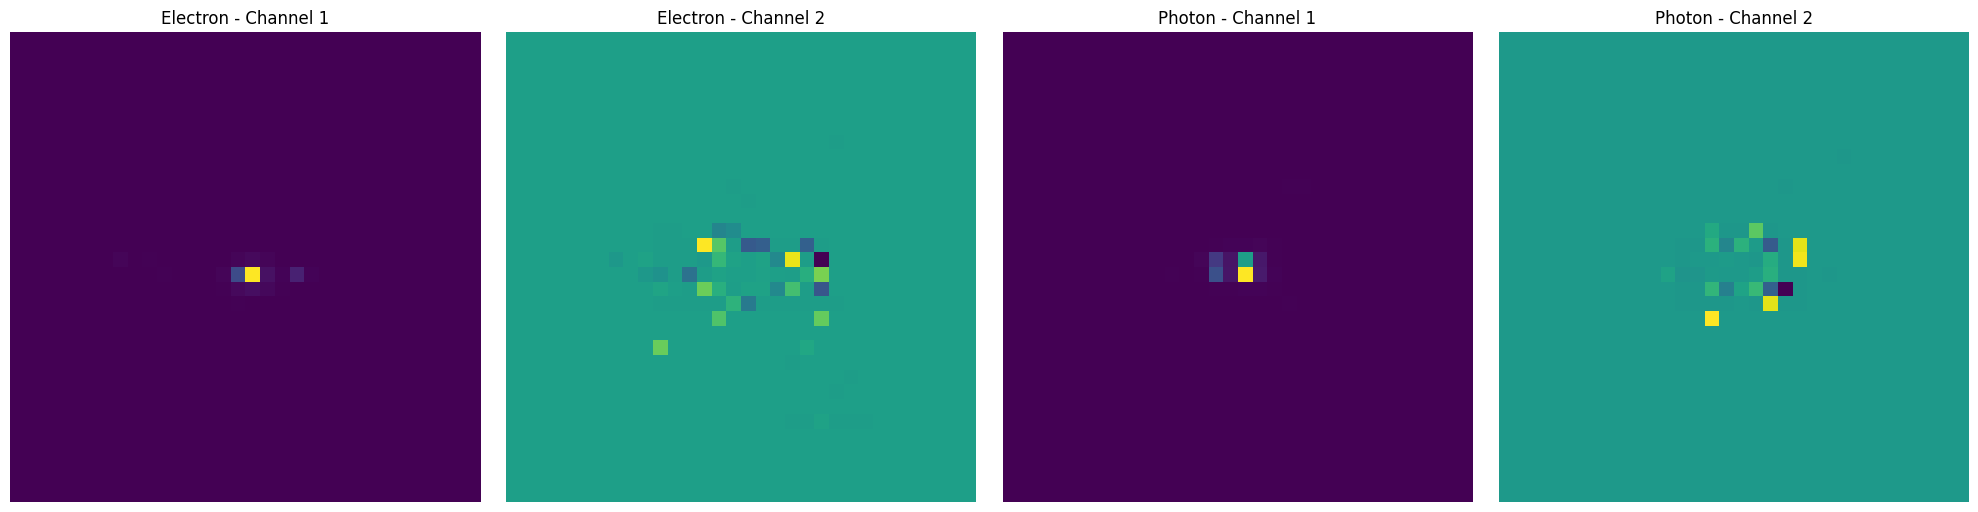

In [4]:
import matplotlib.pyplot as plt

electron_img = electron[0]  
photon_img = photon[0]      

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(electron_img[:, :, 0], cmap='viridis')
axes[0].set_title("Electron - Channel 1")
axes[0].axis("off")

axes[1].imshow(electron_img[:, :, 1], cmap='viridis')
axes[1].set_title("Electron - Channel 2")
axes[1].axis("off")

axes[2].imshow(photon_img[:, :, 0], cmap='viridis')
axes[2].set_title("Photon - Channel 1")
axes[2].axis("off")

axes[3].imshow(photon_img[:, :, 1], cmap='viridis')
axes[3].set_title("Photon - Channel 2")
axes[3].axis("off")

plt.tight_layout()
plt.show()


#### Let's normalize

In [5]:
import torch
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader, random_split

f = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
g = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron = np.asarray(f['X'])
photon = np.asarray(g['X'])

channel1_elect = (electron[:,:,:,0] - electron[:,:,:,0].min()) / (electron[:,:,:,0].max() - electron[:,:,:,0].min())
channel2_elect = (electron[:,:,:,1] - electron[:,:,:,1].min()) / (electron[:,:,:,1].max() - electron[:,:,:,1].min())
channel1_phot = (photon[:,:,:,0] - photon[:,:,:,0].min()) / (photon[:,:,:,0].max() - photon[:,:,:,0].min())
channel2_phot = (photon[:,:,:,1] - photon[:,:,:,1].min()) / (photon[:,:,:,1].max() - photon[:,:,:,1].min())

channel1_elect_reshaped = np.reshape(channel1_elect, (-1, 32*32))
channel2_elect_reshaped = np.reshape(channel2_elect, (-1, 32*32))
channel1_phot_reshaped = np.reshape(channel1_phot, (-1, 32*32))
channel2_phot_reshaped = np.reshape(channel2_phot, (-1, 32*32))

elect_reshaped = np.concatenate([channel1_elect_reshaped, channel2_elect_reshaped], axis=-1)
phot_reshaped = np.concatenate([channel1_phot_reshaped, channel2_phot_reshaped], axis=-1)

elect_reshaped = (elect_reshaped * 255).astype(np.uint8)
phot_reshaped = (phot_reshaped * 255).astype(np.uint8)

elect_labels = np.ones((elect_reshaped.shape[0], 1), dtype=np.uint8)
phot_labels = np.zeros((phot_reshaped.shape[0], 1), dtype=np.uint8)

electron_clean = np.concatenate([elect_reshaped, elect_labels], axis=1)
photon_clean = np.concatenate([phot_reshaped, phot_labels], axis=1)

data = np.concatenate([electron_clean, photon_clean], axis=0)

class ParticleDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample[:-1]
        label = sample[-1]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

dataset = ParticleDataset(data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(16, 7)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, num_classes)
    
    def _make_layer(self, channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(BasicBlock(channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet15(num_classes=1)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 15

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for images, labels in train_loader:
        images = images.view(-1, 2, 32, 32).to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        running_corrects += torch.sum(preds == labels)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

model.eval()
test_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 2, 32, 32).to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        test_corrects += torch.sum(preds == labels)
    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/15, Loss: 0.6347, Accuracy: 0.6447
Epoch 2/15, Loss: 0.5982, Accuracy: 0.6886
Epoch 3/15, Loss: 0.5837, Accuracy: 0.7021
Epoch 4/15, Loss: 0.5746, Accuracy: 0.7102
Epoch 5/15, Loss: 0.5681, Accuracy: 0.7148
Epoch 6/15, Loss: 0.5630, Accuracy: 0.7183
Epoch 7/15, Loss: 0.5587, Accuracy: 0.7208
Epoch 8/15, Loss: 0.5559, Accuracy: 0.7230
Epoch 9/15, Loss: 0.5530, Accuracy: 0.7243
Epoch 10/15, Loss: 0.5500, Accuracy: 0.7266
Epoch 11/15, Loss: 0.5473, Accuracy: 0.7283
Epoch 12/15, Loss: 0.5457, Accuracy: 0.7294
Epoch 13/15, Loss: 0.5439, Accuracy: 0.7303
Epoch 14/15, Loss: 0.5429, Accuracy: 0.7309
Epoch 15/15, Loss: 0.5410, Accuracy: 0.7321
Test Loss: 0.5512, Test Accuracy: 0.7289


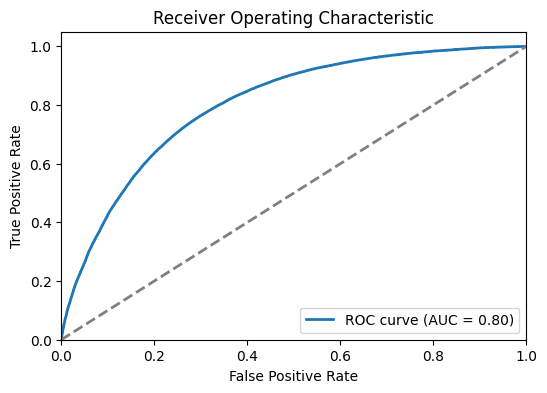

In [9]:
from sklearn.metrics import roc_curve, auc

model.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 2, 32, 32).to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
